In [1]:
import torch
from Utils.Dataloader import Satellite_image_dataset, get_data
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from Models.U_net import U_net
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score
import torch.nn as nn

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def train_net(train_loader, classifier, criterion, optimizer):
  classifier.train()
  loss_ = 0.0
  losses = []
  for i, (images, labels) in enumerate(train_loader):
      images, labels = images.to(DEVICE), labels.to(DEVICE)
      optimizer.zero_grad()
      logits = classifier(images)
      loss = criterion(logits, labels.squeeze())
      loss.backward()
      optimizer.step()
      losses.append(loss)
  return torch.stack(losses).mean().item()

def test_net(test_loader, classifier, criterion,):
    classifier.eval()
    losses = []
    pred_list = []
    label_list = []
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            logits = classifier(images)
            loss = criterion(logits, labels.squeeze())
            pred = torch.where(torch.sigmoid(logits)>=0.5, 1, 0).cpu().numpy()
            pred = np.reshape(pred, (-1,))
            labels = np.reshape(labels.cpu().numpy(), (-1,))
            label_list.append(labels)
            pred_list.append(pred)
            losses.append(loss.item())
        
        all_preds = np.concatenate(pred_list)
        all_labels = np.concatenate(label_list)
        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        coppa = cohen_kappa_score(all_labels, all_preds)
        test_loss = np.mean(losses)
        print("Test result:\n test_loss: {:.4f}, accuracy: {:.4f}, f1: {:.4f}, coppa: {:.4f}".format(test_loss, acc, f1, coppa))
        
    return test_loss, acc, f1, coppa

In [4]:
def plot_losses(train, val, test_frequency, num_epochs):
    plt.plot(train, label="train")
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0)]
    plt.plot(indices, val, label="val")
    plt.title("Loss Plot")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

def plot_acc(train, val, test_frequency, num_epochs):
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0)]
    plt.plot(indices, train, label="train")
    plt.plot(indices, val, label="val")
    plt.title("Accuracy Plot")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

def plot_f1(train, val, test_frequency, num_epochs):
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0)]
    plt.plot(indices, train, label="train")
    plt.plot(indices, val, label="val")
    plt.title("F1 Plot")
    plt.ylabel("F1")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

In [5]:
def train(classifier, num_epochs, train_loader, val_loader, criterion, optimizer, scheduler, test_frequency=5):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    train_f1s =[]
    val_f1s = []

    for epoch in range(1, num_epochs+1):
        print("Starting epoch number " + str(epoch))
        train_loss = train_net(train_loader, classifier, criterion, optimizer)
        train_losses.append(train_loss)
        print("Loss for Training on Epoch " +str(epoch) + " is "+ str(train_loss))
        if(epoch%test_frequency==0 or epoch==1):
            print('Evaluating classifier')
            loss_train, acc_train, f1_train, _ = test_net(train_loader, classifier, criterion)
            train_accs.append(acc_train)
            train_f1s.append(f1_train)
            loss_test, acc_test, f1_test, _ = test_net(val_loader, classifier, criterion)
            val_losses.append(loss_test)
            val_accs.append(acc_test)
            val_f1s.append(f1_test)
        scheduler.step(train_loss)
    
    return classifier, train_losses, val_losses, train_accs, val_accs, train_f1s, val_f1s

In [6]:
batch_size = 8
learning_rate = 1e-3
weight_decay = 1e-3
num_epochs = 50
test_frequency = 1

In [7]:
X, Y = get_data(sites=[1,], years=[2017,2018,2019,], type='Both',base_path='./Data',verbose = True)
x_stacked = np.moveaxis(np.stack(X, -1), [2, 3], [0, 1])
x_stacked = x_stacked.reshape((x_stacked.shape[0], x_stacked.shape[1], -1))
x_reshaped = x_stacked.reshape(-1, x_stacked.shape[-1])
channel_mean = np.mean(x_reshaped, axis=1)
channel_std = np.std(x_reshaped, axis=1)
print(x_reshaped.shape)
print(channel_mean.shape)
print(channel_std.shape)


Loaded 49 images in site 1, year 2017
Loaded 47 images in site 1, year 2018
Loaded 49 images in site 1, year 2019
Completed! Loaded 145 images in total.
(80, 9502720)
(80,)
(80,)


In [8]:
Train_data = Satellite_image_dataset(sites=[1,], years=[2017,2018,2019,],channel_mean=channel_mean, channel_std=channel_std ,type='Both')
Train_dataloader = DataLoader(Train_data, batch_size, shuffle = False)
Test_data = Satellite_image_dataset(sites=[1,], years = [2020, ],channel_mean=channel_mean, channel_std=channel_std, type='Both' )
Test_dataloader = DataLoader(Test_data, batch_size, shuffle = False)

In [9]:
net = U_net(80, 1).to(DEVICE)
criteria = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(net.parameters(), learning_rate,weight_decay= weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor = 0.25, patience = 5, mode='min', verbose=True)

In [10]:
classifier, train_losses, val_losses, train_accs, val_accs, train_f1s, val_f1s = train(net, num_epochs, Train_dataloader, Test_dataloader, criteria, optimizer, scheduler, test_frequency)

Starting epoch number 1
Loss for Training on Epoch 1 is 0.47410282492637634
Evaluating classifier


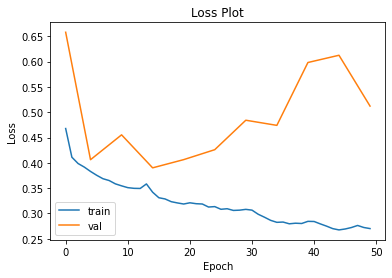

In [ ]:
plot_losses(train_losses, val_losses, test_frequency, num_epochs)

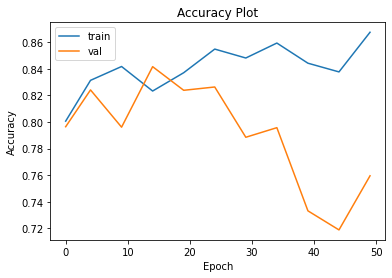

In [ ]:
plot_acc(train_accs, val_accs, test_frequency, num_epochs)

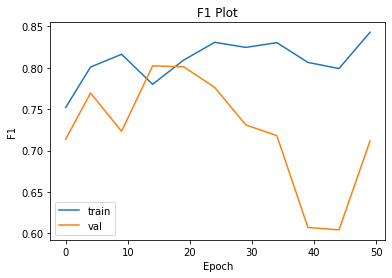

In [ ]:
plot_f1(train_f1s, val_f1s, test_frequency, num_epochs)